In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Prepare Training Images

Text(0, 0.5, 'Folder')

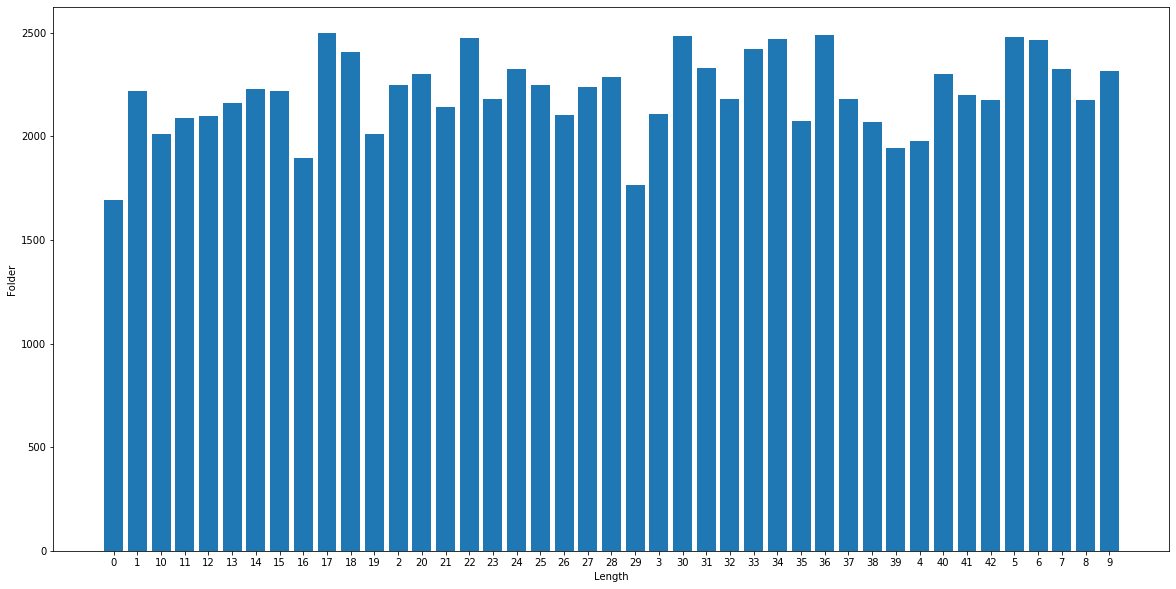

In [116]:
allLen = []
allDir = []

for root, dirs, files in os.walk('dataset/Train/'):
    for dr in dirs:
        leng = len(os.listdir(os.path.join(root, dr)))
        allLen.append(leng)
        allDir.append(dr)
#         print(dr, leng)

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(allDir, allLen)
plt.xlabel('Length')
plt.ylabel('Folder')
#     for file in files:
#         if file.endswith('.png'):
#             sign_images.append(os.path.join(root, file))

# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
   
# Initialising the ImageDataGenerator class. 
# We will pass in the augmentation parameters in the constructor. 
datagen = ImageDataGenerator( 
        rotation_range = 40, 
        zoom_range = 0.2, 
        horizontal_flip = False, 
        brightness_range = (0.5, 1.5)) 
    
# Loading a sample image  
path = "dataset/Train/16"
for image in os.listdir(path):
    img = load_img(os.path.join(path, image))  
    # Converting the input sample image to an array 
    x = img_to_array(img) 
    # Reshaping the input image 
    x = x.reshape((1, ) + x.shape)  

    # Generating and saving 5 augmented samples  
    # using the above defined parameters.  
    i = 0
    for batch in datagen.flow(x, batch_size = 1, 
                              save_to_dir = path,  
                              save_prefix ='image', save_format ='jpeg'): 
        i += 1
        if i > 5: 
            break

# Data Preparing

In [ ]:
training_data = []

def prepare_train_data(category_path):
    for category in os.listdir(category_path):
        image_path = os.path.join(category_path, category)
        for file in os.listdir(image_path):
            try:
                image_class = int(category)
                image = cv2.imread(os.path.join(image_path, file))
                b,g,r = cv2.split(image)       # get b,g,r
                image = cv2.merge([r,g,b])     # switch it to rgb
                img_resize = cv2.resize(image, (50, 50))
                training_data.append([img_resize, image_class])
#                 plt.imshow(img_resize)
#                 plt.show()
            except Exception as e:
                print("Passed e"+str(image_path))
                pass
    return training_data

prepare_train_data("dataset\\Train")

In [120]:
import random

random.shuffle(training_data)

In [121]:
X, y = [], []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)
X.shape

(95530, 50, 50, 3)

# Model Implementation

In [122]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [123]:
chanDim = -1

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


model = Sequential()

model.add(Conv2D(8, (3, 3), padding="same", input_shape=(50,50,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(16, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# second set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(43))
model.add(Activation("softmax"))

model.compile(loss="sparse_categorical_crossentropy", 
             optimizer="adam",
             metrics=['accuracy'])

# 30% on validation set
history = model.fit(X, y, batch_size=32, epochs=30, validation_split=0.3, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])



model.save('Traffic-sign-6.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 66871 samples, validate on 28659 samples
Epoch 1/30
66871/66871 [==============================] - 182s 3ms/sample - loss: 2.6845 - acc: 0.2234 - val_loss: 1.6007 - val_acc: 0.4908
Epoch 2/30
66871/66871 [==============================] - 182s 3ms/sample - loss: 1.5183 - acc: 0.5015 - val_loss: 0.9960 - val_acc: 0.6865
Epoch 3/30
66871/66871 [==============================] - 181s 3ms/sample - loss: 1.1026 - acc: 0.6318 - val_loss: 0.5988 - val_acc: 0.8218
Epoch 4/30
66871/66871 [==============================] - 182s 3ms/sample - loss: 0.8582 - acc: 0.7161 - val_loss: 0.4135 - val_acc: 0.8739
Epoch 5/30
66871/66871 [==============================] - 181s 3ms/sample - loss: 0.7175 - acc: 0.7676 - val_loss: 0.3320 - val_acc: 0.9072
Epoch 6/30
66871/66871 [==============================] - 181s 

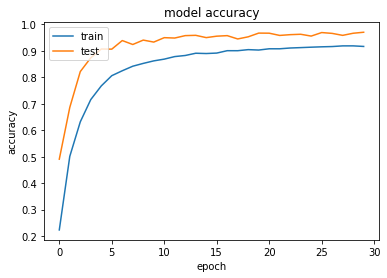

In [124]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

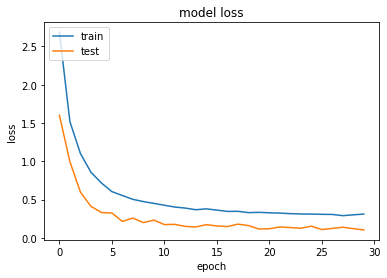

In [125]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [126]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 8)         224       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 16)        2320      
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25, 16)        0         
__________

# Model Testing

In [130]:
import random

testing_data = []

def prepare_test_data(path):
    file = random.choice(os.listdir(path))
    try:
        image = cv2.imread(os.path.join(path, file))
        b,g,r = cv2.split(image)       # get b,g,r
        image = cv2.merge([r,g,b])     # switch it to rgb
        img_resize = cv2.resize(image, (50, 50))
        testing_data.append(img_resize)
        plt.imshow(img_resize)
        plt.show()
    except Exception as e:
        print("Passed e")
        pass
    return testing_data

In [3]:
import tensorflow as tf
loadmodel = tf.keras.models.load_model('Traffic-sign-6.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
len(testing_data)

1

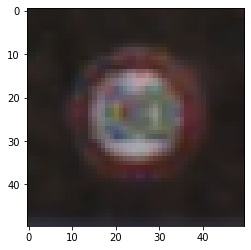

Class : 5


In [134]:
testing_data = []

prediction = loadmodel.predict(np.array(prepare_test_data("dataset\\Test")).astype('float32'))

print("Class : " + str(np.argmax(prediction)))

# Detection (HaarFeatures) and Classify

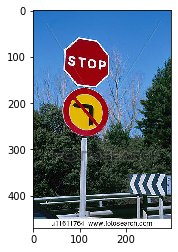

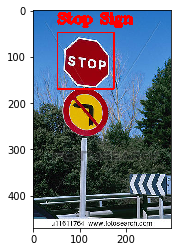

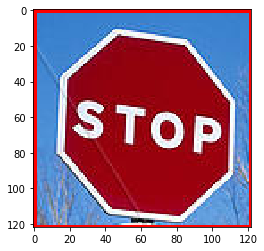

In [11]:
import numpy as np
import cv2

stop_cascade = cv2.CascadeClassifier('stop_sign.xml')
car_cascade = cv2.CascadeClassifier('cars2.xml')
trlight_cascade = cv2.CascadeClassifier('traffic_light.xml')

image = cv2.imread("Detection/shapes.jpg") # read
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # read

img = cv2.imread("Detection/shapes.jpg") # read
b,g,r = cv2.split(img)       # get b,g,r
img = cv2.merge([r,g,b])     # switch it to rgb

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # to gray

stops = stop_cascade.detectMultiScale(gray, 1.3, 5) # detect stops
cars = car_cascade.detectMultiScale(gray, 1.1, 1) # detect cars
trafficlights = trlight_cascade.detectMultiScale(gray, 1.1, 1) # detect traffic

# loop over detected features
for (x,y,w,h) in stops:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.putText(img, "Stop Sign", (x, y - 20), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 5)
    roi_gray = gray[y:y+h, x:x+w]
    cropped = img[y:y+h, x:x+w]
for (ex,ey,ew,eh) in cars:
    cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,0,255),2)
    cv2.putText(img, "Car", (ex, ey - 20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
for (tx,ty,tw,th) in trafficlights:
    cv2.rectangle(img,(tx,ty),(tx+tw,ty+th),(0,255,0),2)
    cv2.putText(img, "Traffic light", (tx, ty - 20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

# show image with detected features
plt.imshow(image)
plt.show()
plt.imshow(img)
plt.show()

# show detected features
plt.imshow(cropped)
plt.show()

# Predict Traffic Sign after Crop

In [106]:
testing_data = []

b,g,r = cv2.split(image)       # get b,g,r
image = cv2.merge([r,g,b])     # switch it to rgb
cropped_resize = cv2.resize(cropped, (50, 50))
testing_data.append(cropped_resize)

prediction = loadmodel.predict(np.array(testing_data).astype('float32'))

print("Class : " + str(np.argmax(prediction)))

Class : 14
